<a href="https://colab.research.google.com/github/snu-digital-finance/ProductionML/blob/main/FinalInputDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [110]:
from dataclasses import dataclass
from scipy.stats import beta as beta_dist
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import shutil

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
rng = np.random.default_rng(42)

plt.rcParams.update({
    'font.size': 14,
    'figure.titlesize': 18, 'figure.titleweight': 'bold',
    'figure.subplot.hspace': 0.3, 'figure.subplot.wspace': 0.3,
    'axes.titlesize': 14, 'axes.labelsize': 13,
    'xtick.labelsize': 12, 'ytick.labelsize': 12,
    'legend.fontsize': 12,
})

def _plot_hist(ax, data, label, color):
  ax.hist(data, label=label, color=color, bins=30, alpha=0.6, edgecolor='black')

def _set_title_label(ax, title, xlabel="Value", ylabel="Count"):
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()
    ax.grid(True)

# 1. Why ReLU -> Nonlinear

/tmp/ipython-input-1472902335.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


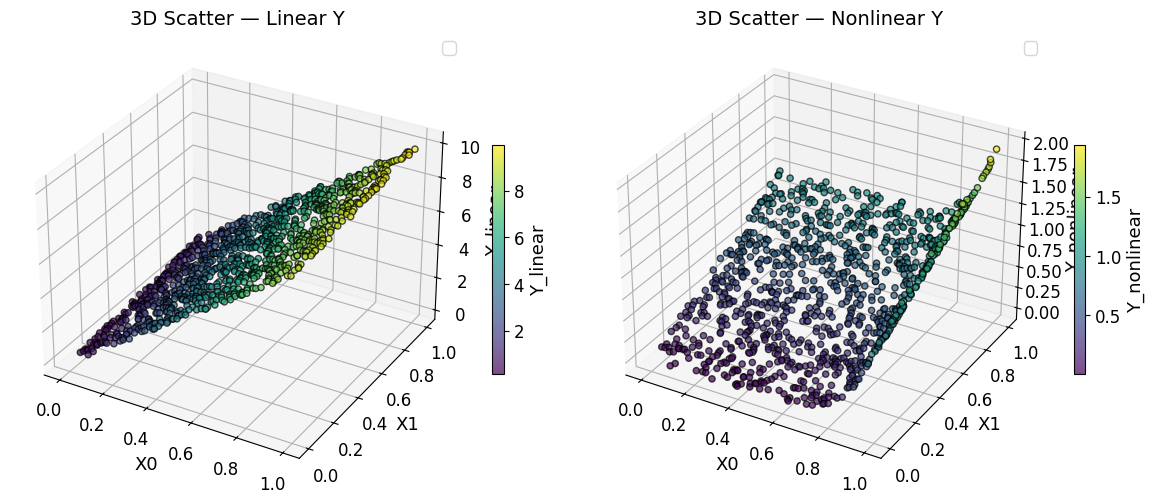

In [112]:
num_samples, num_features = 1000, 2
randfunc = lambda size: np.random.uniform(low=0, high=1, size=size)

# X.shape = (num_features, num_samples)
X = np.array([randfunc(num_samples) for _ in range(num_features)])

# 선형/비선형 Y
Y_linear = 9*X[0] + 1*X[1]
Y_nonlinear = X[0]**9 + X[1]**1

fig = plt.figure(figsize=(12, 5))

# Linear
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
sc1 = ax1.scatter(X[0], X[1], Y_linear, c=Y_linear, cmap='viridis', alpha=0.7, edgecolor='k')
_set_title_label(ax1, "3D Scatter — Linear Y", "X0", "X1")
ax1.set_zlabel("Y_linear")
fig.colorbar(sc1, ax=ax1, shrink=0.5, label="Y_linear")

# Nonlinear
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
sc2 = ax2.scatter(X[0], X[1], Y_nonlinear, c=Y_nonlinear, cmap='viridis', alpha=0.7, edgecolor='k')
_set_title_label(ax2, "3D Scatter — Nonlinear Y", "X0", "X1")
ax2.set_zlabel("Y_nonlinear")
fig.colorbar(sc2, ax=ax2, shrink=0.5, label="Y_nonlinear")

plt.tight_layout()
plt.show()

# 2. Why Transformer? -> Style

In [99]:
def make_KL_datasets(num_samples, betas_reg, betas_dist, iid=True):
    u, eps = np.asarray(np.random.rand(num_samples * len(betas_reg))), 1e-12
    u_K, u_L = np.clip(u[0::2], eps, 1-eps), np.clip(u[1::2], eps, 1-eps)
    K_share, L_share = beta_dist.ppf(u_K, *betas_dist['K']), beta_dist.ppf(u_L, *betas_dist['L'])

    randfunc = lambda s: np.random.rand(num_samples) * (s.max() - s.min()) + s.min()
    df = dict(
        K=pd.DataFrame({"firm_type": "K-intense", "K_share": K_share, "L_share": randfunc(K_share),
                        "Y":K_share**betas_reg['K'][0], "LogY": betas_reg['K'][0]*K_share}),
        L=pd.DataFrame({"firm_type": "L-intense", "K_share": randfunc(1-L_share) , "L_share": 1-L_share,
                        "Y":(1-L_share)**betas_reg['L'][1], "LogY": betas_reg['L'][1]*(1-L_share)})
    )
    if not iid:
      df['K']['L_share'], df['L']['K_share'] = 1 - K_share, L_share
      df['K']['Y'] *= (1-K_share)**betas_reg['K'][1]
      df['L']['Y'] *= (L_share)**betas_reg['L'][0]
      df['K']['LogY'] += betas_reg['K'][1] * (1-K_share)
      df['L']['LogY'] += betas_reg['L'][0] * (L_share)

    return pd.concat(list(df.values()), ignore_index=True)


#beta from regression != a, b for beta distribution
betas_reg=dict(K=(9,1), L=(1,9))
betas_dist=dict(K=(5,2), L=(2,5))

df_firms_dep = make_KL_datasets(
    num_samples=1000,
    betas_reg=betas_reg,
    betas_dist=betas_dist,
    iid=False,
)
df_firms_iid = make_KL_datasets(
    num_samples=1000,
    betas_reg=betas_reg,
    betas_dist=betas_dist,
    iid=True,
)
df_firms_iid.head()

,firm_type,K_share,L_share,Y,LogY
0,K-intense,0.765885,0.701313,0.090672,6.892966
1,K-intense,0.843095,0.306205,0.215224,7.587857
2,K-intense,0.538051,0.887411,0.003779,4.842462
3,K-intense,0.671646,0.672136,0.027814,6.044814
4,K-intense,0.809908,0.293599,0.149941,7.289172


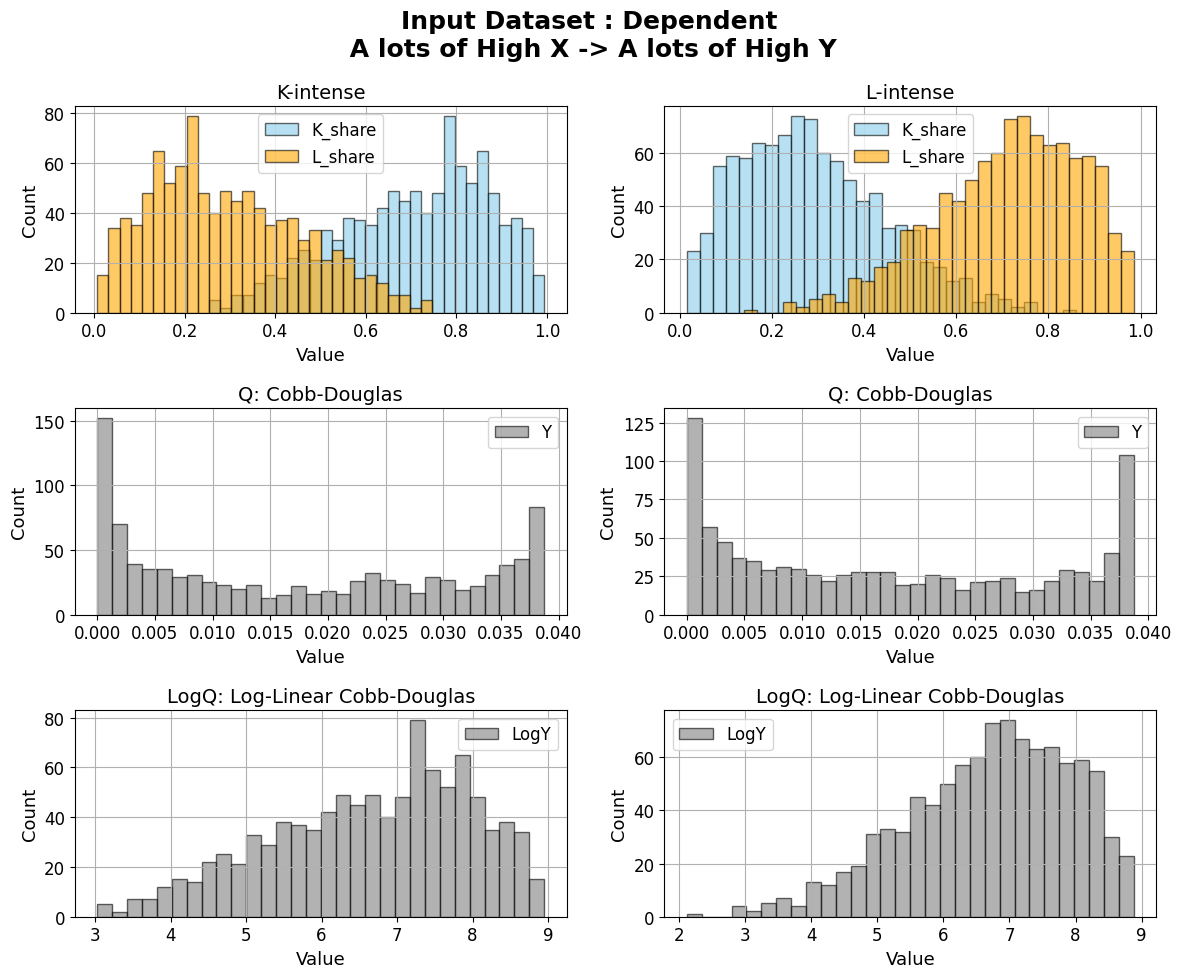

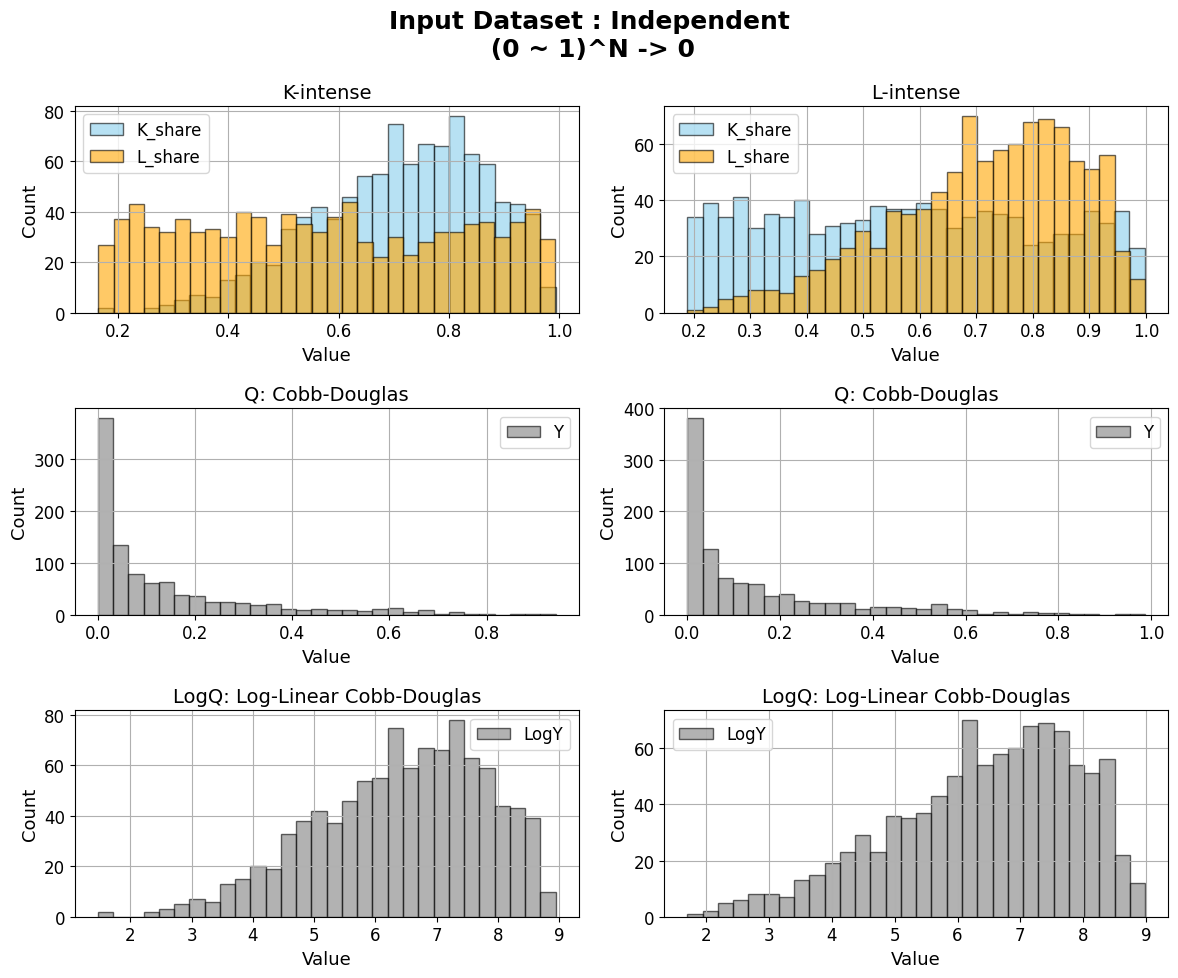

In [100]:
def plot_input_2d(df, subtitle=''):
    fig, axes = plt.subplots(
        nrows=3, ncols=len(df["firm_type"].unique()), figsize=(12, 10),
    )
    fig.suptitle(f"Input Dataset {subtitle}")
    for col, (firm_type, group) in enumerate(df.groupby("firm_type")):
        _plot_hist(axes[0, col], group["K_share"], color='skyblue', label='K_share')
        _plot_hist(axes[0, col], group["L_share"], color='orange', label='L_share')
        _set_title_label(axes[0, col], firm_type)

        _plot_hist(axes[1, col], group["Y"], color="gray", label="Y")
        _set_title_label(axes[1, col], "Q: Cobb-Douglas")

        _plot_hist(axes[2, col], group["LogY"], color="gray", label="LogY")
        _set_title_label(axes[2, col], "LogQ: Log-Linear Cobb-Douglas")

    plt.tight_layout()
    plt.show()


plot_input_2d(df_firms_dep, ": Dependent\n A lots of High X -> A lots of High Y")
print()
plot_input_2d(df_firms_iid, ": Independent\n (0 ~ 1)^N -> 0")

/tmp/ipython-input-3367344422.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/tmp/ipython-input-3367344422.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


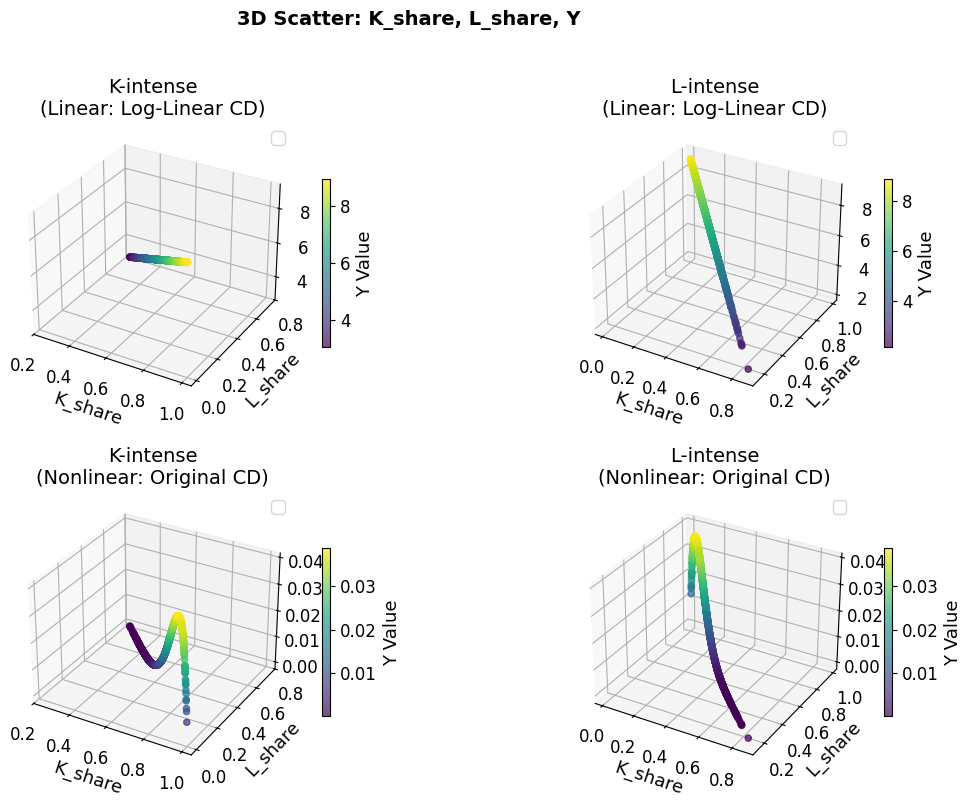

/tmp/ipython-input-3367344422.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/tmp/ipython-input-3367344422.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


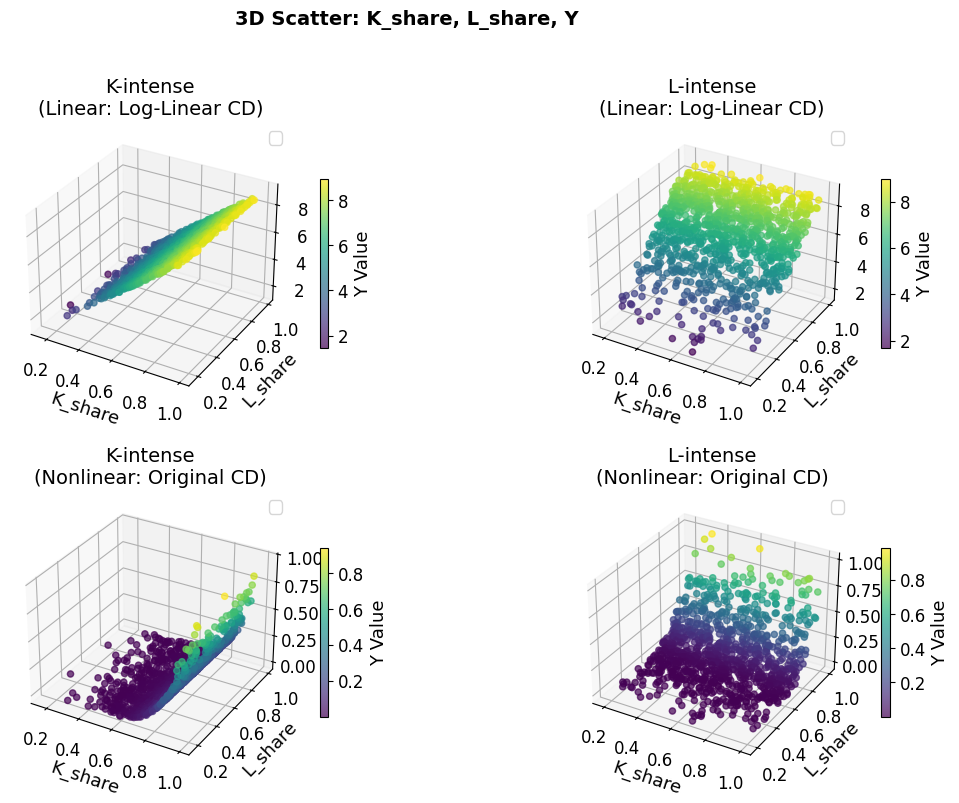

In [105]:
def plot_input_3d(df):
    firm_types = df["firm_type"].unique()
    fig = plt.figure(figsize=(12, 8))
    fig.suptitle("3D Scatter: K_share, L_share, Y", fontsize=14)
    df_nonlinear = df[["firm_type", "K_share", "L_share", "Y"]]
    df_linear = df[["firm_type", "K_share", "L_share", "LogY"]].rename(columns={"LogY": "Y"})

    for row, (title, df) in enumerate([("Linear: Log-Linear CD", df_linear), ("Nonlinear: Original CD", df_nonlinear)]):
        for col, (firm_type, group) in enumerate(df.groupby("firm_type")):
            ax = fig.add_subplot(2, 2, row*2 + col + 1, projection='3d')
            sc = ax.scatter(group["K_share"], group["L_share"], group["Y"], c=group["Y"], cmap="viridis", alpha=0.7)
            _set_title_label(ax, f"\n{firm_type}\n({title})", 'K_share', 'L_share')
            fig.colorbar(sc, ax=ax, label="Y Value", shrink=0.6)

    plt.tight_layout()
    plt.show()

plot_input_3d(df_firms_dep)
print()
plot_input_3d(df_firms_iid)